In [15]:
import pickle
import numpy as np
import tensorflow as tf 


In [2]:
import matplotlib.pyplot as plt

# 原始数据

In [3]:
pickle_file = r'datasets/notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


In [4]:
train_labels

array([6, 6, 9, ..., 8, 4, 8], dtype=int32)

# 数据预处理
将原始数据处理成模型可接受的形式

In [5]:
image_size = 28
num_labels = 10
num_channels = 1 

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size, image_size, num_channels
                              )).astype(np.float32)
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


# 创建CNN模型
包含两个卷积层及一个全连接层

In [6]:
learning_rate = 0.05
batch_size = 16
num_labels = 10
img_size = 28
img_channel = 1
num_steps = 1001

In [7]:
X = tf.placeholder(tf.float32,
                   shape=(None, img_size, img_size, img_channel))
y = tf.placeholder(tf.float32, shape=(None, num_labels))

In [8]:
weights = {
    'conv1': tf.Variable(tf.truncated_normal([5, 5, 1, 16], stddev=0.1)),
    'conv2': tf.Variable(tf.truncated_normal([5, 5, 16, 16], stddev=0.1)),
    'full1': tf.Variable(tf.truncated_normal([7 * 7 * 16, 64], stddev=0.1)),
    'out': tf.Variable(tf.truncated_normal([64, num_labels], stddev=0.1))
}

biases = {
    'conv1': tf.Variable(tf.zeros([16])),
    'conv2': tf.Variable(tf.constant(1.0, shape=[16])),
    'full1': tf.Variable(tf.constant(1.0, shape=[64])),
    'out': tf.Variable(tf.constant(1.0, shape=[num_labels]))
}

In [9]:
def build_nets(X):
    conv1 = tf.nn.conv2d(X, weights['conv1'], strides=[1, 2, 2, 1],
                         padding='SAME')
    conv1 = tf.nn.relu(tf.add(conv1, biases['conv1']))

    conv2 = tf.nn.conv2d(conv1, weights['conv2'], strides=[1, 2, 2, 1],
                         padding='SAME')
    conv2 = tf.nn.relu(tf.add(conv2, biases['conv2']))

    shape = weights['full1'].get_shape().as_list()[0]
    full1 = tf.reshape(conv2, [-1, shape])
    full1 = tf.matmul(full1, weights['full1'])
    full1 = tf.nn.relu(tf.add(full1, biases['full1']))

    out = tf.add(tf.matmul(full1, weights['out']), biases['out'])
    return out

In [10]:
logits = build_nets(X)
loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))


optimizer = tf.train.GradientDescentOptimizer(
    learning_rate=learning_rate).minimize(loss)

y_pred = tf.nn.softmax(logits)
y_pred_correct = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
acc = tf.reduce_mean(tf.cast(y_pred_correct, tf.float32))

init = tf.global_variables_initializer()

W0925 11:07:18.697465 140286728304448 deprecation.py:323] From <ipython-input-10-536041b00ef1>:3: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [11]:
with tf.Session() as sess:
    sess.run(init)
    print('Initialized...')
    print('-'*80)
    for i in range(num_steps):
        offset = (i * batch_size) % (train_labels.shape[0] - batch_size)
        batch_x = train_dataset[offset:offset + batch_size, :, :, :]
        batch_y = train_labels[offset:offset + batch_size, :]
        feed_dict = {X: batch_x, y: batch_y}
        _, loss_val, train_acc = sess.run([optimizer, loss, acc],
                                          feed_dict=feed_dict)

        if i % 50 == 0:
            print('Step {}: Minibatch Loss={}, Training Accuracy={}'.format(i, loss_val, train_acc))
            val_acc = sess.run(acc,
                               feed_dict={X: valid_dataset, y: valid_labels})
            print('Validation Accuracy={}'.format(val_acc))
            print('-'*80)
    print('Optimization Finished!')
    test_acc = sess.run(acc, feed_dict={X: test_dataset, y: test_labels})
    print('Test accuracy: {}'.format(test_acc))

Initialized...
--------------------------------------------------------------------------------
Step 0: Minibatch Loss=3.00974440574646, Training Accuracy=0.125
Validation Accuracy=0.10000000149011612
--------------------------------------------------------------------------------
Step 50: Minibatch Loss=1.8500714302062988, Training Accuracy=0.25
Validation Accuracy=0.5400000214576721
--------------------------------------------------------------------------------
Step 100: Minibatch Loss=0.7997140884399414, Training Accuracy=0.6875
Validation Accuracy=0.6937999725341797
--------------------------------------------------------------------------------
Step 150: Minibatch Loss=0.918752908706665, Training Accuracy=0.625
Validation Accuracy=0.7712000012397766
--------------------------------------------------------------------------------
Step 200: Minibatch Loss=0.4610944986343384, Training Accuracy=0.875
Validation Accuracy=0.7864000201225281
---------------------------------------------

# 优化模型

## 池化层+小步长
将上述模型的步长减为 1，增加池化层
- 模型测试精度增加 1%

In [12]:
def build_nets(X):
    conv1 = tf.nn.conv2d(X, weights['conv1'], strides=[1, 1, 1, 1],
                         padding='SAME')
    conv1 = tf.nn.relu(tf.add(conv1, biases['conv1']))
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                          padding='SAME')

    conv2 = tf.nn.conv2d(conv1, weights['conv2'], strides=[1, 1, 1, 1],
                         padding='SAME')
    conv2 = tf.nn.relu(tf.add(conv2, biases['conv2']))
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                          padding='SAME')

    shape = weights['full1'].get_shape().as_list()[0]
    full1 = tf.reshape(conv2, [-1, shape])
    full1 = tf.matmul(full1, weights['full1'])
    full1 = tf.nn.relu(tf.add(full1, biases['full1']))

    out = tf.add(tf.matmul(full1, weights['out']), biases['out'])
    return out

In [13]:
logits = build_nets(X)
loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))


optimizer = tf.train.GradientDescentOptimizer(
    learning_rate=learning_rate).minimize(loss)

y_pred = tf.nn.softmax(logits)
y_pred_correct = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
acc = tf.reduce_mean(tf.cast(y_pred_correct, tf.float32))

init = tf.global_variables_initializer()

In [14]:
with tf.Session() as sess:
    sess.run(init)
    print('Initialized...')
    print('-'*80)
    for i in range(num_steps):
        offset = (i * batch_size) % (train_labels.shape[0] - batch_size)
        batch_x = train_dataset[offset:offset + batch_size, :, :, :]
        batch_y = train_labels[offset:offset + batch_size, :]
        feed_dict = {X: batch_x, y: batch_y}
        _, loss_val, train_acc = sess.run([optimizer, loss, acc],
                                          feed_dict=feed_dict)

        if i % 50 == 0:
            print('Step {}: Minibatch Loss={}, Training Accuracy={}'.format(i, loss_val, train_acc))
            val_acc = sess.run(acc,
                               feed_dict={X: valid_dataset, y: valid_labels})
            print('Validation Accuracy={}'.format(val_acc))
            print('-'*80)
    print('Optimization Finished!')
    test_acc = sess.run(acc, feed_dict={X: test_dataset, y: test_labels})
    print('Test accuracy: {}'.format(test_acc))

Initialized...
--------------------------------------------------------------------------------
Step 0: Minibatch Loss=3.4627625942230225, Training Accuracy=0.0625
Validation Accuracy=0.10000000149011612
--------------------------------------------------------------------------------
Step 50: Minibatch Loss=2.2258143424987793, Training Accuracy=0.125
Validation Accuracy=0.3012999892234802
--------------------------------------------------------------------------------
Step 100: Minibatch Loss=1.1995855569839478, Training Accuracy=0.375
Validation Accuracy=0.6039999723434448
--------------------------------------------------------------------------------
Step 150: Minibatch Loss=0.8889767527580261, Training Accuracy=0.75
Validation Accuracy=0.767300009727478
--------------------------------------------------------------------------------
Step 200: Minibatch Loss=0.48465919494628906, Training Accuracy=0.875
Validation Accuracy=0.7727000117301941
------------------------------------------

## 增加模型层数+`dropout`
提升模型精度
- 增加模型复杂度
- 全连接层添加 dropout

In [52]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, w):
    return tf.nn.conv2d(x, w, strides=[1,1,1,1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1, 2, 2, 1], padding='SAME')

def conv_layer(input_, shape):
    w = weight_variable(shape)
    b = bias_variable([shape[3]])
    return tf.nn.relu(conv2d(input_, w) + b)

def full_layer(input_, size):
    insize = int(input_.get_shape()[1])
    w = weight_variable([insize, size])
    b = bias_variable([size])
    return tf.matmul(input_, w) + b

In [53]:
image_size = 28
batch_size = 128
num_labels = 10
graph = tf.Graph()

with graph.as_default():    
    x = tf.placeholder(tf.float32, shape=[None,28,28,1])
    y = tf.placeholder(tf.float32, shape=[None, 10])
    keep_prob = tf.placeholder(tf.float32)
    
    conv1 = conv_layer(x, shape=[5, 5, 1, 16])
    conv1_pool = max_pool_2x2(conv1)
    
    conv2 = conv_layer(conv1_pool, shape=[5,5,16,32])
    conv2_pool = max_pool_2x2(conv2)
    
    conv3 = conv_layer(conv2_pool, shape=[5,5,32,64])
    conv3_pool = max_pool_2x2(conv3)
    
    conv3_flat = tf.reshape(conv3_pool, [-1, 4*4*64])
    conv3_drop = tf.nn.dropout(conv3_flat, keep_prob=keep_prob)
    
    full_1 = tf.nn.relu(full_layer(conv3_drop, 256))
    full1_drop = tf.nn.dropout(full_1, keep_prob=keep_prob)
    
    y_pred = full_layer(full1_drop, 10)
    
    cross_entropy = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_pred))
    
    train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)
    
    correct_predicetion = tf.equal(tf.argmax(y,1), tf.argmax(y_pred, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_predicetion, tf.float32))

In [54]:
num_steps = 3001

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    print("Initialized")
    print('-'*80)
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)

        batch_data = train_dataset[offset:(offset + batch_size)]
        batch_labels = train_labels[offset:(offset + batch_size)]

        sess.run(train_step,feed_dict={x: batch_data, 
                                       y: batch_labels,
                                       keep_prob:0.5})
        
        if (step % 500 == 0):
            loss, train_acc = sess.run([cross_entropy,accuracy],
                                       feed_dict={x: batch_data, 
                                                  y :batch_labels,
                                                  keep_prob:0.5})
            print("step {}:".format(step))
            print("Minibatch loss: {}, accuracy: {}".format(loss,train_acc))
            val_acc = sess.run(accuracy,feed_dict={x: valid_dataset,
                                                   y: valid_labels,
                                                   keep_prob:0.5})
            print("Validation accuracy: {}".format(val_acc))
            print('-'*80)

    print('Optimization Finished!')
    test_acc = sess.run(accuracy,feed_dict={x: test_dataset, 
                                            y: test_labels,
                                            keep_prob:1.0})
    print("Test accuracy: {}".format(test_acc))

Initialized
--------------------------------------------------------------------------------
step 0:
Minibatch loss: 4.313622951507568, accuracy: 0.125
Validation accuracy: 0.10050000250339508
--------------------------------------------------------------------------------
step 500:
Minibatch loss: 0.4675438106060028, accuracy: 0.8671875
Validation accuracy: 0.8490999937057495
--------------------------------------------------------------------------------
step 1000:
Minibatch loss: 0.5774704217910767, accuracy: 0.8671875
Validation accuracy: 0.8683000206947327
--------------------------------------------------------------------------------
step 1500:
Minibatch loss: 0.3340117633342743, accuracy: 0.9140625
Validation accuracy: 0.8784000277519226
--------------------------------------------------------------------------------
step 2000:
Minibatch loss: 0.32236236333847046, accuracy: 0.9140625
Validation accuracy: 0.879800021648407
--------------------------------------------------------

## `LeNet5`+优化方法
- 参数更新方法：AdamOptimizer 比 GradientDescentOptimizer 精度提升 3%

In [104]:
X = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])
y = tf.placeholder(tf.float32, shape=[None, 10])

In [105]:
weights = {
    'conv1': tf.Variable(tf.truncated_normal([5, 5, 1, 6], stddev=0.1)),
    'conv2': tf.Variable(tf.truncated_normal([5, 5, 6, 16], stddev=0.1)),
    'fc3': tf.Variable(tf.truncated_normal([5 * 5 * 16, 120], stddev=0.1)),
    'fc4': tf.Variable(tf.truncated_normal([120, 84], stddev=0.1)),
    'out': tf.Variable(tf.truncated_normal([84, 10], stddev=0.1))
}

biases = {
    'conv1': tf.Variable(tf.constant(0.1, shape=[6])),
    'conv2': tf.Variable(tf.constant(0.1, shape=[16])),
    'fc3': tf.Variable(tf.constant(0.1, shape=[120])),
    'fc4': tf.Variable(tf.constant(0.1, shape=[84])),
    'out': tf.Variable(tf.constant(0.1, shape=[10]))
}

def build_nets(X, weights, biases):
    z1 = tf.nn.conv2d(X, weights['conv1'], strides=[1, 1, 1, 1], padding='SAME')
    y1 = tf.nn.relu(tf.add(z1, biases['conv1']))
    y1 = tf.nn.max_pool2d(y1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    z2 = tf.nn.conv2d(y1, weights['conv2'], strides=[1, 1, 1, 1], padding='VALID')
    y2 = tf.nn.relu(tf.add(z2, biases['conv2']))
    y2 = tf.nn.max_pool2d(y2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    y2 = tf.reshape(y2, [-1, weights['fc3'].get_shape().as_list()[0]])
    z3 = tf.matmul(y2, weights['fc3'])
    y3 = tf.nn.relu(tf.add(z3, biases['fc3']))

    z4 = tf.matmul(y3, weights['fc4'])
    y4 = tf.nn.relu(tf.add(z4, biases['fc4']))

    out = tf.add(tf.matmul(y4, weights['out']), biases['out'])
    return out

In [106]:
logits = build_nets(X, weights, biases)
y_pred = tf.nn.softmax(logits)

loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))

y_pred_correct = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
acc = tf.reduce_mean(tf.cast(y_pred_correct, tf.float32))

optimizer = tf.train.AdamOptimizer(1e-3).minimize(loss)

init = tf.global_variables_initializer()

In [107]:
num_steps = 2001

with tf.Session() as sess:
    sess.run(init)
    print("Initialized")
    print('-'*80)
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)

        batch_data = train_dataset[offset:(offset + batch_size)]
        batch_labels = train_labels[offset:(offset + batch_size)]

        sess.run(optimizer,feed_dict={X: batch_data, y: batch_labels})
        
        if (step % 200 == 0):
            loss_val, train_acc = sess.run([loss,acc],
                                       feed_dict={X: batch_data, 
                                                  y :batch_labels})
            print("step {}:".format(step))
            print("Minibatch loss: {}, accuracy: {}".format(loss_val,train_acc))
            val_acc = sess.run(acc,feed_dict={X: valid_dataset,
                                                   y: valid_labels})
            print("Validation accuracy: {}".format(val_acc))
            print('-'*80)

    print('Optimization Finished!')
    test_acc = sess.run(acc,feed_dict={X: test_dataset,y: test_labels})
    print("Test accuracy: {}".format(test_acc))

Initialized
--------------------------------------------------------------------------------
step 0:
Minibatch loss: 2.2333452701568604, accuracy: 0.203125
Validation accuracy: 0.14190000295639038
--------------------------------------------------------------------------------
step 200:
Minibatch loss: 0.5003485679626465, accuracy: 0.84375
Validation accuracy: 0.8303999900817871
--------------------------------------------------------------------------------
step 400:
Minibatch loss: 0.45962750911712646, accuracy: 0.8359375
Validation accuracy: 0.8550999760627747
--------------------------------------------------------------------------------
step 600:
Minibatch loss: 0.40207576751708984, accuracy: 0.8671875
Validation accuracy: 0.8690999746322632
--------------------------------------------------------------------------------
step 800:
Minibatch loss: 0.6581531763076782, accuracy: 0.8203125
Validation accuracy: 0.8799999952316284
-------------------------------------------------------

## `Keras Callbacks`

CNN 结构如下：
            
`In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out`

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.metrics import confusion_matrix
import itertools

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style='white', context='notebook', palette='deep')

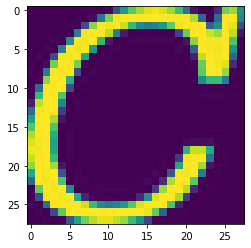

In [90]:
g = plt.imshow(train_dataset[11][:,:,0])

In [91]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [94]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [99]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [95]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [96]:
epochs = 5
batch_size = 128

In [100]:
history = model.fit(train_dataset, train_labels, batch_size = batch_size, epochs = epochs,
                    validation_data = (valid_dataset, valid_labels), verbose = 2)

Train on 200000 samples, validate on 10000 samples
Epoch 1/5
 - 694s - loss: 0.4321 - acc: 0.8719 - val_loss: 0.3204 - val_acc: 0.9082
Epoch 2/5
 - 693s - loss: 0.3372 - acc: 0.9005 - val_loss: 0.3156 - val_acc: 0.9137
Epoch 3/5
 - 692s - loss: 0.3289 - acc: 0.9040 - val_loss: 0.3031 - val_acc: 0.9134
Epoch 4/5
 - 689s - loss: 0.3292 - acc: 0.9036 - val_loss: 0.3039 - val_acc: 0.9145
Epoch 5/5
 - 693s - loss: 0.3332 - acc: 0.9035 - val_loss: 0.3109 - val_acc: 0.9126


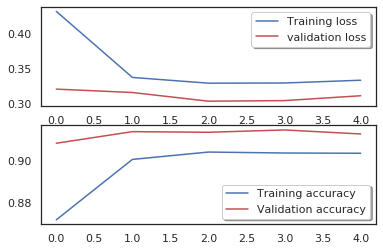

In [101]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

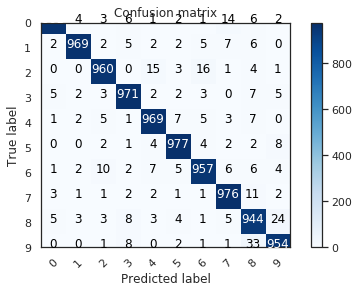

In [102]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
Y_pred = model.predict(test_dataset)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(test_labels,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(10))     

In [103]:
y_pred_correct = tf.equal(tf.argmax(y_pred, 1), tf.argmax(test_labels, 1))
acc = tf.reduce_mean(tf.cast(y_pred_correct, tf.float32))
print("Test accuracy: {}".format(test_acc))

Test accuracy: 0.911899983882904
